# Colab

In [2]:
!nvidia-smi -L  

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [5]:
!pip install timm

# Parameters

In [6]:
import torch
import timm
import pandas as pd

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cpu')

In [8]:
params = {
    # "model": "vit_large_patch16_224",
    "model": "resnet18",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "im_size": 224,
    "lr": 1e-3,
    "batch_size": 128,
    "num_workers": 2,
    "epochs": 20,
    "folds":3,
    "lr_scheduler": True,
    "early_stopping": True,
    "augmentation": True,
    "path": "/content/drive/MyDrive/ISIC/2016"
}
PATH = params['path']

# Generate splits

## csv

In [8]:
import os
os.listdir(PATH)

['ISBI2016_ISIC_Part3_Training_Data.zip',
 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Test_Data.zip',
 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Training_Data',
 'ISBI2016_ISIC_Part3_Test_Data',
 'val_fold3.csv',
 'train_fold3.csv',
 'folds',
 'splits',
 'train_split.csv',
 'val_split.csv']

In [9]:
import pandas as pd
train_csv = f'{PATH}/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
test_csv = f'{PATH}/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

### add target in case benign_malignant only (2016)

In [10]:
header_list = ['image_name','benign_malignant']
train = pd.read_csv(train_csv, names=header_list, index_col=False)

header_list = ['image_name','target']
test = pd.read_csv(test_csv, names=header_list, index_col=False)

In [11]:
def to_int(label):
  if label == "benign":
    return 0.0
  elif label == "malignant":
    return 1.0
train['target'] = train.benign_malignant.apply(to_int)

## Add path to csv

In [12]:
def to_path(image_name, path):
  return path + image_name + '.jpg'

In [13]:
train_path = f'{PATH}/ISBI2016_ISIC_Part3_Training_Data/'
test_path = f'{PATH}/ISBI2016_ISIC_Part3_Test_Data/'

In [14]:
train['path'] = train.image_name.apply(to_path, path = train_path)

test['path'] = test.image_name.apply(to_path, path=test_path)

In [15]:
train.shape, test.shape

((900, 4), (379, 3))

### Train Exploration

#### Target histogram

80.77777777777779
19.22222222222222
0.0    727
1.0    173
Name: target, dtype: int64


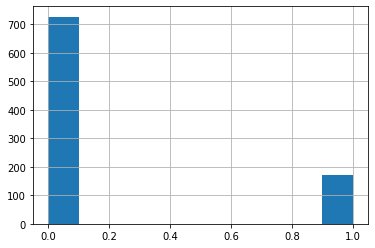

In [16]:
print(train['target'].value_counts()[0]/len(train['target'])*100)
print(train['target'].value_counts()[1]/len(train['target'])*100)

print(train['target'].value_counts())
train['target'].hist()

#### Genre histogram

In [17]:
try:
  train['sex'].hist()
except:
  print("not found in dataframe")
   

not found in dataframe


#### Age histogram

In [18]:
try:
  train['age_approx'].value_counts()
except:
  print("not found in dataframe")

not found in dataframe


In [19]:
try:
  train['age_approx'].hist(bins=len(train['age_approx'].unique()))
except:
  print("not found in dataframe")

not found in dataframe


#### Anatom site

In [20]:
try:
  train['anatom_site_general_challenge'].hist()
except:
  print("not found in dataframe")

not found in dataframe


## Hold-out with stratify for training

In [21]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train, random_state=42, test_size=0.33, shuffle=True, stratify=train['target'])
train_split.shape, val_split.shape

((603, 4), (297, 4))

In [22]:
train_split.to_csv(f'{PATH}/train_split.csv', index=False)
val_split.to_csv(f'{PATH}/val_split.csv', index=False)

### Exploration of split distrubition

#### train split

54.11111111111111
12.88888888888889
0.0    487
1.0    116
Name: target, dtype: int64


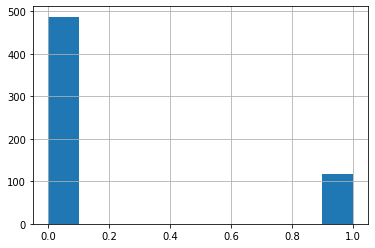

In [23]:
print(train_split['target'].value_counts()[0]/len(train['target'])*100)
print(train_split['target'].value_counts()[1]/len(train['target'])*100)

print(train_split['target'].value_counts())
train_split['target'].hist()

#### val split

26.666666666666668
6.333333333333334
0.0    240
1.0     57
Name: target, dtype: int64


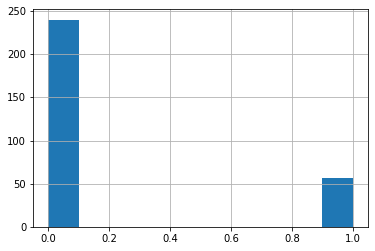

In [24]:
print(val_split['target'].value_counts()[0]/len(train['target'])*100)
print(val_split['target'].value_counts()[1]/len(train['target'])*100)

print(val_split['target'].value_counts())
val_split['target'].hist()

# Subset

### Load subset

In [ ]:
_, subset = train_test_split(train_split, random_state=42, test_size=0.1, shuffle=True, stratify=train_split['target'])
subset.shape

(2220, 9)

In [ ]:
subset.to_csv(f'{PATH}/subset.csv', index=False)

#### Exploration distrubution of subset

98.24324324324324
1.7567567567567568
0    2181
1      39
Name: target, dtype: int64


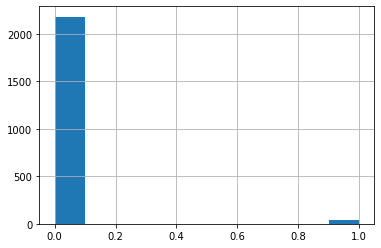

In [ ]:
print(subset['target'].value_counts()[0]/len(subset['target'])*100)
print(subset['target'].value_counts()[1]/len(subset['target'])*100)

print(subset['target'].value_counts())
subset['target'].hist()

# Folds

## Create csv with folds

In [ ]:
import numpy as np
from sklearn import model_selection
KFOLD = params['folds']
kf = model_selection.StratifiedKFold(n_splits=KFOLD, random_state=42, shuffle=True)
for fold_, (train_idx, val_idx) in enumerate(kf.split(X=train,y=train['target'])):
  train.loc[val_idx,'kfold'] = fold_
  train.to_csv(f'{PATH}/train_fold{KFOLD}.csv')
  print("Fold:",fold_+1)
  print(train_idx.shape, val_idx.shape)

# Load csv

## Hold-out split

In [9]:
train_csv = f'{PATH}/train_split.csv'
val_csv = f'{PATH}/val_split.csv'

train = pd.read_csv(train_csv)
val = pd.read_csv(val_csv)
train.shape, val.shape

((603, 4), (297, 4))

## Stratified kFolds 

In [143]:
KFOLD= params['folds']
train_csv = f'{PATH}/train_fold{KFOLD}.csv'
train = pd.read_csv(train_csv)

## Subset csv load

In [142]:
train_csv = f'{PATH}/subset.csv'
val_csv = f'{PATH}/val_split.csv'

train = pd.read_csv(train_csv)
val = pd.read_csv(val_csv)
train.shape, val.shape

FileNotFoundError: ignored

# Dataset.py

In [10]:
import os
import cv2
import numpy as np
import albumentations
import torch
from torch.utils.data import Dataset

In [11]:
# from skimage import io
# from skimage.transform import resize

class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # image = self.transform(image=image)["image"].astype(np.float32)/255.
      # image = self.transform(image=image)["image"].astype(np.float32)
      image = self.transform(image=image)["image"]
      # image = image.transpose(2, 0, 1)/255.
      image = image.transpose(2, 0, 1)
    else:
      image = cv2.resize(image, (params['im_size'],params['im_size']))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/ 255.
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  def __len__(self) -> int:
    return len(self.images)

# Calculate mean and std

## Method 1

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean, std = get_mean_and_std(DataLoader(MelanomaDataset(train['path'], train['target'])))
print(mean)
print(std)

(0.7232643, 0.6180579, 0.56661755)
(0.16529222, 0.1724447, 0.19304909)


## Method 2

In [ ]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    return means, stds

In [ ]:
compute_img_mean_std(train['path'])

100%|██████████| 900/900 [00:43<00:00, 20.66it/s]


(224, 224, 3, 900)
mean [0.64762354, 0.64762354, 0.64762354]
std [0.19479683, 0.19479683, 0.19479683]


([0.64762354, 0.64762354, 0.64762354], [0.19479683, 0.19479683, 0.19479683])

## Method 3

In [ ]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs,_ in tqdm(DataLoader(MelanomaDataset(train['path'], train['target']))):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 900/900 [00:51<00:00, 17.59it/s]


In [ ]:
# pixel count
count = len(train['path']) * params['im_size'] * params['im_size']

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))


mean: tensor([0.7233, 0.6181, 0.5666])
std:  tensor([0.1653, 0.1724, 0.1930])


# Augmentation

In [12]:
mean= (0.7232643, 0.6180579, 0.56661755)

std= (0.16529222, 0.1724447, 0.19304909)

In [13]:
import albumentations as A

def transform_aug(im_size):
  transforms_train = A.Compose(
      [
       A.Transpose(p=0.5),
       A.VerticalFlip(p=0.5),
       A.HorizontalFlip(p=0.5),
       A.RandomBrightness(limit=0.2, p=0.75),
       A.RandomContrast(limit=0.2, p=0.75),
       A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.Blur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
       A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
                ], p=0.7),
       A.CLAHE(clip_limit=4.0, p=0.7),
       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
       A.Resize(im_size, im_size),
       A.Cutout(max_h_size=int(im_size * 0.375), max_w_size=int(im_size * 0.375), num_holes=1, p=0.7),
       A.Normalize(mean = (0.7232643, 0.6180579, 0.56661755),std = (0.16529222, 0.1724447, 0.19304909))
       ])
  transforms_val = A.Compose(
      [
       A.SmallestMaxSize(max_size=160),
       A.CenterCrop(height=128, width=128),
       A.Resize(im_size, im_size),
       A.Normalize(mean = (0.7232643, 0.6180579, 0.56661755),std = (0.16529222, 0.1724447, 0.19304909))
       ])
  return transforms_train, transforms_val

# Metrics

In [14]:
from collections import defaultdict
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()
    
  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += 1
    metric["avg"] = metric["val"] / metric["count"]

  def get(self, metric_name):
    return self.metrics.get(metric_name).get('avg')
    
  def __str__(self):
    return " | ".join(
        ["{metric_name}: {avg:.{float_precision}f}".format(metric_name=metric_name,
                                                           avg=metric["avg"],
                                                           float_precision=self.float_precision)
        for (metric_name, metric) in self.metrics.items()])

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

threshold = 0.5

def auc_score(outputs, targets):
  # outputs = torch.sigmoid(outputs)
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  auc = roc_auc_score(targets, outputs)
  return auc

def f1_score_(outputs, targets):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  f1 = f1_score(targets, outputs, average='weighted')
  return f1

def recall_scr(outputs, targets, pos_label = 1):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  recall = recall_score(targets, outputs, pos_label=pos_label)
  return recall

def preicision_score(outputs, targets):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  preicision = average_precision_score(targets, outputs)
  return preicision

def accuracy_score(outputs, targets):
  # output = torch.sigmoid(outputs) >= 0.5
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  return torch.true_divide((targets == outputs).sum(dim=0), outputs.size(0)).item()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def save_roc_curve(outputs, targets, path, label, plot=False,pos_label=1):
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(targets, outputs, pos_label=pos_label)
  plt.plot(false_positive_rate[2],true_positive_rate[2],color="darkorange",label="ROC curve (area = %0.2f)" % roc_auc_score(targets, outputs))
  plt.plot(false_positive_rate, true_positive_rate, lw=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([-0.05, 1.05])
  plt.ylim([0.0, 1.05])
  plt.savefig(f"{path}/folds/{label}.png")
  plt.legend(loc="lower right")
  plt.title('Receiver operating characteristic ROC')
  plt.show() if plot else plt.close()
  plt.clf()

def save_confusion_matrix(outputs, targets, path, label, classes=None, plot=False, percentage=True):
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  cf_matrix = confusion_matrix(targets, outputs)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) if percentage else cf_matrix, index = [i for i in classes], columns = [i for i in classes])
  sn.heatmap(df_cm, annot=True, cmap='Blues')
  plt.title(f'{label} Confusion Matrix')
  plt.savefig(f'{path}/folds/{label}_cm.png')
  plt.show() if plot else plt.close()
  plt.clf()

# Learning rate scheduler | Early stopping

## Learning rate scheduler

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
class LRSchedulerPlateau():
  def __init__(self, optimizer, patience_t=1, mode="min", factor=0.8, min_lr=1e-7):
    self.optimizer = optimizer
    self.patience_t = patience_t
    self.mode = mode
    self.factor = factor
    self.min_lr = min_lr
    self.lr_scheduler = ReduceLROnPlateau( self.optimizer, mode='min', patience=self.patience_t, factor=self.factor, min_lr=self.min_lr, verbose=True)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

## Early stopping

In [17]:
class EarlyStopping():
  def __init__(self, patience=5, min_delta=0.0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
    if self.counter >= self.patience:
      print('INFO: Early stopping')
      self.early_stop = True

# Model

In [18]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=True, num_classes = n_class)
    def forward(self, x):
        x = self.model(x)
        return x

# Train.py

## Definition of training and validation functions

In [19]:
from torch.utils.data import DataLoader

def data_loader(df_train, df_valid, transform_tuple= (None,None), batch_size=None):
  dataset = {'train': MelanomaDataset(df_train['path'], df_train['target'],transform=transform_tuple[0]),
             'val': MelanomaDataset(df_valid['path'], df_valid['target'],transform=transform_tuple[1])}
  train_loader_ = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, pin_memory=True)
  val_loader_ = DataLoader(dataset['val'], batch_size=batch_size, pin_memory=True)
  return train_loader_, val_loader_

In [20]:
from statistics import mean
def fit(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)

  train_outputs = torch.tensor([]).to(params['device'])
  train_targets = torch.tensor([]).to(params['device'])
  train_loss = []

  val_steps=0

  for _, batch in enumerate(stream, start=1):
    images, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)
    outputs = model(images)
    loss = criterion(outputs, targets)

    train_outputs = torch.cat([train_outputs, outputs])
    train_targets = torch.cat([train_targets, targets])
    train_loss.append(loss.item())
    
    accuracy = accuracy_score(outputs, targets)
    f1 = f1_score_(outputs, targets)
    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
        
    try:
      auc = auc_score(outputs, targets)
      metric_monitor.update("AUC", auc)
    except:
      continue

    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # if val_steps==5:
    #   break
    # val_steps+=1
  accuracy = accuracy_score(train_outputs, train_targets)
  f1 = f1_score_(train_outputs, train_targets)    
  auc = auc_score(train_outputs, train_targets)
  return mean(train_loss), accuracy, f1, auc

In [21]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  val_outputs = torch.tensor([]).to(params['device'])
  val_targets = torch.tensor([]).to(params['device'])
  val_loss = []
  val_steps = 0
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      outputs = model(images)
      loss = criterion(outputs, targets)
      
      val_outputs = torch.cat([val_outputs, outputs])
      val_targets = torch.cat([val_targets, targets])
      val_loss.append(loss.item())
      
      accuracy = accuracy_score(outputs, targets)
      f1 = f1_score_(outputs, targets)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      try:
        auc = auc_score(outputs, targets)
        metric_monitor.update("AUC", auc)
      except:
        continue
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
      # if val_steps==5:
      #   break
      # val_steps+=1
  accuracy = accuracy_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)    
  auc = auc_score(val_outputs, val_targets)
  return mean(val_loss), accuracy, f1, auc

## Hold-out fit

In [22]:
from torch.utils.data import DataLoader

transforms_train, transforms_val = transform_aug(params['im_size'])

dataset = {
    'train': MelanomaDataset(train['path'], train['target'],transform=transforms_train),
    'val': MelanomaDataset(val['path'], val['target'],transform=transforms_val)
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

# images, labels = next(iter(train_loader))
# images.shape, labels.shape

In [ ]:
from tqdm import tqdm
import time

from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
fit_lr = []
start = time.time()

model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)
optimizer = AdamP(model.parameters(), lr=params['lr'])
criterion = nn.BCEWithLogitsLoss()
lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

model.to(params['device'])

for epoch in range(1, params["epochs"] + 1):
  train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = fit(train_loader, model, criterion, optimizer, epoch, params)
  val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params)
  train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
  val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_f1.append(val_epoch_f1);val_auc.append(val_epoch_auc)
  if params['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if params['early_stopping']:
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
      break
  lr_ = get_lr(optimizer)
  fit_lr.append(lr_)
  print('learning rate:',lr_)
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
Epoch: 1. Train. Loss: 0.697 | Accuracy: 0.723 | F1: 0.723 | AUC: 0.559: 100%|██████████| 5/5 [16:46<00:00, 201.39s/it]
Epoch: 1. Validation. Loss: 1.322 | Accuracy: 0.401 | F1: 0.430 | AUC: 0.532: 100%|██████████| 3/3 [02:05<00:00, 41.83s/it]


learning rate: 0.001


Epoch: 2. Train. Loss: 0.576 | Accuracy: 0.793 | F1: 0.730 | AUC: 0.630:  80%|████████  | 4/5 [10:03<02:29, 149.28s/it]

In [ ]:
metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
save_metrics(metrics, names, fold='Hold_out', path=PATH, plot=False, mode='splits')
save_epoch_lr(fit_lr, lr_label= f'{fold}_learning rate', path=PATH, plot=False, mode='splits')

## Define visuals

In [ ]:
import matplotlib.pyplot as plt

def save_epoch_lr(lr_list, lr_label, path, plot = False, mode='folds'):
    plt.figure(figsize=(7, 4))
    plt.plot(lr_list, color='red', label=lr_label)
    plt.xlabel('epochs')
    plt.ylabel(lr_label)
    plt.legend()
    plt.savefig(f"{path}/{mode}/{lr_label}.png")
    plt.show() if plot else plt.close()
    

In [ ]:
import matplotlib.pyplot as plt

def save_metrics(metric_list, labels_list, fold, path, plot=False, mode='folds'):
  for i in range(len(labels_list)):
    plt.figure(figsize=(7, 4))
    plt.plot(metric_list[i][0], color='green', label=f'train {labels_list[i]}')
    plt.plot(metric_list[i][1], color='orange', label=f'validataion {labels_list[i]}')
    plt.xlabel('epochs')
    plt.ylabel(labels_list[i])
    plt.legend()
    plt.savefig(f"{path}/{mode}/fold{fold}_{labels_list[i]}.png")
    plt.show() if plot else plt.close()

## Examples

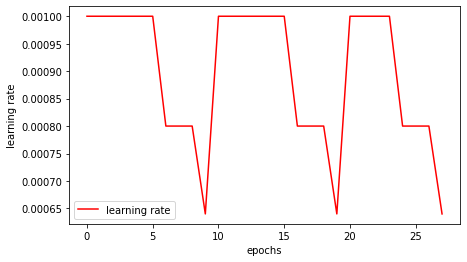

In [ ]:
import matplotlib.pyplot as plt

lr_label= 'learning rate'
plt.figure(figsize=(7, 4))
plt.plot(fit_lr, color='red', label=lr_label)
plt.xlabel('epochs')
plt.ylabel(lr_label)
plt.legend()
plt.savefig(f"./{lr_label}.png")
plt.show()

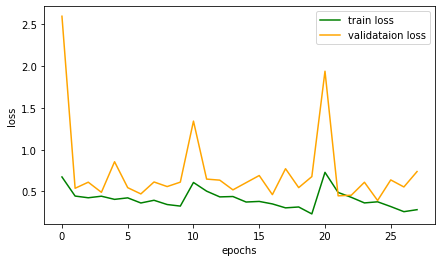

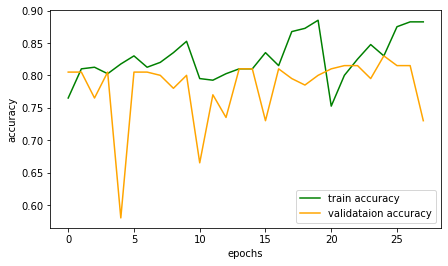

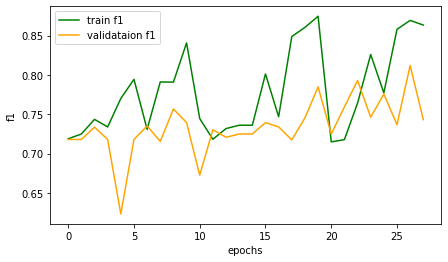

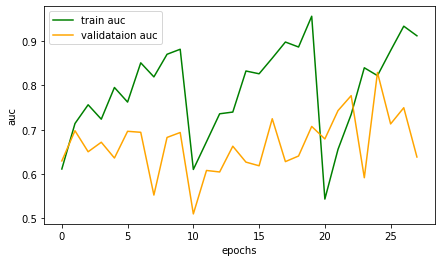

In [ ]:
import matplotlib.pyplot as plt

metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
for i in range(len(names)):
  plt.figure(figsize=(7, 4))
  plt.plot(metrics[i][0], color='green', label=f'train {names[i]}')
  plt.plot(metrics[i][1], color='orange', label=f'validataion {names[i]}')
  plt.xlabel('epochs')
  plt.ylabel(names[i])
  plt.legend()
  plt.savefig(f"./{names[i]}.png")
  plt.show()

## Kfold fit

#### Define function to extract folds from training data

In [ ]:
def get_folds(df, fold):
  '''
  Return training and validation dataframe for specific fold
  df: Whole training + validation dataset
  fold: Specific fold index
  '''
  df_train = df[df.kfold != fold].reset_index(drop=True)
  df_valid = df[df.kfold == fold].reset_index(drop=True)
  return df_train, df_valid

In [ ]:
from tqdm import tqdm
import time


from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
start = time.time()

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

for fold in range(params['folds']):
  best_ = 0
  fit_lr = []
  model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)
  model.to(params['device'])
  optimizer = AdamP(model.parameters(), lr=params['lr'])
  criterion = nn.BCEWithLogitsLoss()
  lr_scheduler = LRSchedulerPlateau(optimizer)
  early_stopping = EarlyStopping()
  train_fold, val_fold = get_folds(train,fold)
  train_loader, val_loader = data_loader(train_fold, val_fold, transform_tuple= aug_transform, batch_size=params['batch_size'])
  for epoch in range(1, params["epochs"] + 1):
    lr_ = get_lr(optimizer)
    fit_lr.append(lr_)
    print('\nLearning rate:',lr_)

    train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = fit(train_loader, model, criterion, optimizer, epoch, params)
    print(f'\nOverall Training. Loss: {train_epoch_loss:.3f}, Accuracy: {train_epoch_acc:.3f}, F1: {train_epoch_f1:.3f}, AUC: {train_epoch_auc:.3f}\n') 
    val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params)
    print(f'\nOverall Validation. Loss: {val_epoch_loss:.3f}, Accuracy: {val_epoch_acc:.3f}, F1: {val_epoch_f1:.3f}, AUC: {val_epoch_auc:.3f}\n')   
    train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
    val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_f1.append(val_epoch_f1);val_auc.append(val_epoch_auc)
    
    if val_epoch_auc > best_:
      best_ = val_epoch_auc
      aug = 'aug' if params['augmentation'] else 'no_aug'
      torch.save(model, f'{PATH}/folds/fold{fold+1}_{params["model"]}_{aug}.pth')
      print(f"Saving current best model for fold {fold+1}: {best_:.3f}\n")

    if params['lr_scheduler']:
      lr_scheduler(val_epoch_loss)
    if params['early_stopping']:
      early_stopping(val_epoch_loss)
      if early_stopping.early_stop:
        break
    if epoch ==5:
      break
  metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
  names = ['loss', 'accuracy', 'f1', 'auc']
  save_metrics(metrics, names, fold=fold+1, path=PATH, plot=False)
  save_epoch_lr(fit_lr, lr_label= f'Fold{fold+1}_learning rate', path=PATH, plot=False)

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Learning rate: 0.001


Epoch: 1. Train. Loss: 0.662 | Accuracy: 0.750 | F1: 0.742 | AUC: 0.687:  20%|██        | 5/25 [01:54<07:36, 22.81s/it]



Overall Training. Loss: 0.662, Accuracy: 0.750, F1: 0.756, AUC: 0.614



Epoch: 1. Validation. Loss: 1.190 | Accuracy: 0.586 | F1: 0.604 | AUC: 0.430:  54%|█████▍    | 7/13 [02:13<01:54, 19.06s/it]



Overall Validation. Loss: 1.190, Accuracy: 0.586, F1: 0.617, AUC: 0.402

Saving current best model for fold 1: 0.402


Learning rate: 0.001


Epoch: 2. Train. Loss: 0.935 | Accuracy: 0.792 | F1: 0.748 | AUC: 0.612:  20%|██        | 5/25 [01:30<06:03, 18.18s/it]



Overall Training. Loss: 0.935, Accuracy: 0.792, F1: 0.752, AUC: 0.572



Epoch: 2. Validation. Loss: 2.779 | Accuracy: 0.320 | F1: 0.341 | AUC: 0.597:  54%|█████▍    | 7/13 [00:16<00:14,  2.42s/it]



Overall Validation. Loss: 2.779, Accuracy: 0.320, F1: 0.330, AUC: 0.568

Saving current best model for fold 1: 0.568

INFO: Early stopping counter 1 of 5

Learning rate: 0.001


Epoch: 3. Train. Loss: 0.585 | Accuracy: 0.812 | F1: 0.782 | AUC: 0.754:  20%|██        | 5/25 [01:13<04:52, 14.64s/it]



Overall Training. Loss: 0.585, Accuracy: 0.812, F1: 0.785, AUC: 0.677



Epoch: 3. Validation. Loss: 2.813 | Accuracy: 0.805 | F1: 0.726 | AUC: 0.488:  54%|█████▍    | 7/13 [00:16<00:14,  2.42s/it]



Overall Validation. Loss: 2.813, Accuracy: 0.805, F1: 0.718, AUC: 0.514

Epoch     3: reducing learning rate of group 0 to 8.0000e-04.
INFO: Early stopping counter 2 of 5

Learning rate: 0.0008


Epoch: 4. Train. Loss: 0.380 | Accuracy: 0.854 | F1: 0.810 | AUC: 0.874:  20%|██        | 5/25 [00:59<03:57, 11.86s/it]



Overall Training. Loss: 0.380, Accuracy: 0.854, F1: 0.820, AUC: 0.777



Epoch: 4. Validation. Loss: 1.105 | Accuracy: 0.805 | F1: 0.726 | AUC: 0.608:  54%|█████▍    | 7/13 [00:17<00:14,  2.43s/it]



Overall Validation. Loss: 1.105, Accuracy: 0.805, F1: 0.718, AUC: 0.554


Learning rate: 0.0008


Epoch: 5. Train. Loss: 0.423 | Accuracy: 0.821 | F1: 0.762 | AUC: 0.774:  24%|██▍       | 6/25 [01:05<03:27, 10.94s/it]



Overall Training. Loss: 0.423, Accuracy: 0.821, F1: 0.764, AUC: 0.727



Epoch: 5. Validation. Loss: 0.557 | Accuracy: 0.805 | F1: 0.726 | AUC: 0.746:  54%|█████▍    | 7/13 [00:16<00:14,  2.43s/it]



Overall Validation. Loss: 0.557, Accuracy: 0.805, F1: 0.718, AUC: 0.659

Saving current best model for fold 1: 0.659


Learning rate: 0.001


Epoch: 1. Train. Loss: 0.780 | Accuracy: 0.741 | F1: 0.749 | AUC: 0.648:  24%|██▍       | 6/25 [00:49<02:37,  8.30s/it]



Overall Training. Loss: 0.780, Accuracy: 0.741, F1: 0.739, AUC: 0.655



Epoch: 1. Validation. Loss: 5.745 | Accuracy: 0.198 | F1: 0.076 | AUC: 0.601:  38%|███▊      | 5/13 [00:32<00:51,  6.44s/it]



Overall Validation. Loss: 5.745, Accuracy: 0.198, F1: 0.065, AUC: 0.573

Saving current best model for fold 2: 0.573


Learning rate: 0.001


Epoch: 2. Train. Loss: 0.820 | Accuracy: 0.802 | F1: 0.765 | AUC: 0.545:  20%|██        | 5/25 [00:43<02:55,  8.80s/it]



Overall Training. Loss: 0.820, Accuracy: 0.802, F1: 0.774, AUC: 0.571



Epoch: 2. Validation. Loss: 1.042 | Accuracy: 0.781 | F1: 0.721 | AUC: 0.568:  38%|███▊      | 5/13 [00:11<00:18,  2.30s/it]



Overall Validation. Loss: 1.042, Accuracy: 0.781, F1: 0.720, AUC: 0.619

Saving current best model for fold 2: 0.619


Learning rate: 0.001


Epoch: 3. Train. Loss: 0.497 | Accuracy: 0.830 | F1: 0.780 | AUC: 0.628:  24%|██▍       | 6/25 [00:44<02:20,  7.41s/it]



Overall Training. Loss: 0.497, Accuracy: 0.830, F1: 0.781, AUC: 0.655



Epoch: 3. Validation. Loss: 1.704 | Accuracy: 0.812 | F1: 0.750 | AUC: 0.713:  38%|███▊      | 5/13 [00:11<00:18,  2.30s/it]



Overall Validation. Loss: 1.704, Accuracy: 0.812, F1: 0.753, AUC: 0.705

Saving current best model for fold 2: 0.705

INFO: Early stopping counter 1 of 5

Learning rate: 0.001


Epoch: 4. Train. Loss: 0.608 | Accuracy: 0.760 | F1: 0.685 | AUC: 0.676:  20%|██        | 5/25 [00:30<02:02,  6.14s/it]



Overall Training. Loss: 0.608, Accuracy: 0.760, F1: 0.690, AUC: 0.590



Epoch: 4. Validation. Loss: 0.524 | Accuracy: 0.771 | F1: 0.776 | AUC: 0.776:  38%|███▊      | 5/13 [00:11<00:18,  2.27s/it]



Overall Validation. Loss: 0.524, Accuracy: 0.771, F1: 0.771, AUC: 0.748

Saving current best model for fold 2: 0.748


Learning rate: 0.001


Epoch: 5. Train. Loss: 0.487 | Accuracy: 0.823 | F1: 0.777 | AUC: 0.697:  20%|██        | 5/25 [00:36<02:25,  7.27s/it]



Overall Training. Loss: 0.487, Accuracy: 0.823, F1: 0.782, AUC: 0.616



Epoch: 5. Validation. Loss: 0.844 | Accuracy: 0.719 | F1: 0.709 | AUC: 0.689:  38%|███▊      | 5/13 [00:11<00:18,  2.27s/it]



Overall Validation. Loss: 0.844, Accuracy: 0.719, F1: 0.716, AUC: 0.686

INFO: Early stopping counter 1 of 5

Learning rate: 0.001


Epoch: 1. Train. Loss: 0.782 | Accuracy: 0.719 | F1: 0.708 | AUC: 0.552:  20%|██        | 5/25 [00:31<02:07,  6.39s/it]



Overall Training. Loss: 0.782, Accuracy: 0.719, F1: 0.712, AUC: 0.585



Epoch: 1. Validation. Loss: 2.548 | Accuracy: 0.196 | F1: 0.152 | AUC: 0.650:  46%|████▌     | 6/13 [00:26<00:30,  4.38s/it]



Overall Validation. Loss: 2.548, Accuracy: 0.196, F1: 0.128, AUC: 0.605

Saving current best model for fold 3: 0.605


Learning rate: 0.001


Epoch: 2. Train. Loss: 0.905 | Accuracy: 0.740 | F1: 0.693 | AUC: 0.560:  20%|██        | 5/25 [00:33<02:13,  6.67s/it]



Overall Training. Loss: 0.905, Accuracy: 0.740, F1: 0.692, AUC: 0.542



Epoch: 2. Validation. Loss: 0.496 | Accuracy: 0.795 | F1: 0.763 | AUC: 0.446:  46%|████▌     | 6/13 [00:15<00:18,  2.60s/it]



Overall Validation. Loss: 0.496, Accuracy: 0.795, F1: 0.755, AUC: 0.551


Learning rate: 0.001


Epoch: 3. Train. Loss: 0.470 | Accuracy: 0.823 | F1: 0.783 | AUC: 0.700:  20%|██        | 5/25 [00:29<01:57,  5.85s/it]



Overall Training. Loss: 0.470, Accuracy: 0.823, F1: 0.782, AUC: 0.695



Epoch: 3. Validation. Loss: 1.304 | Accuracy: 0.839 | F1: 0.778 | AUC: 0.615:  46%|████▌     | 6/13 [00:15<00:18,  2.58s/it]



Overall Validation. Loss: 1.304, Accuracy: 0.839, F1: 0.766, AUC: 0.667

Saving current best model for fold 3: 0.667

INFO: Early stopping counter 1 of 5

Learning rate: 0.001


Epoch: 4. Train. Loss: 0.516 | Accuracy: 0.812 | F1: 0.743 | AUC: 0.816:  20%|██        | 5/25 [00:31<02:06,  6.33s/it]



Overall Training. Loss: 0.516, Accuracy: 0.812, F1: 0.752, AUC: 0.720



Epoch: 4. Validation. Loss: 1.299 | Accuracy: 0.839 | F1: 0.778 | AUC: 0.632:  46%|████▌     | 6/13 [00:15<00:18,  2.58s/it]



Overall Validation. Loss: 1.299, Accuracy: 0.839, F1: 0.766, AUC: 0.674

Saving current best model for fold 3: 0.674

Epoch     4: reducing learning rate of group 0 to 8.0000e-04.
INFO: Early stopping counter 2 of 5

Learning rate: 0.0008


Epoch: 5. Train. Loss: 0.485 | Accuracy: 0.771 | F1: 0.684 | AUC: 0.758:  20%|██        | 5/25 [00:27<01:48,  5.44s/it]



Overall Training. Loss: 0.485, Accuracy: 0.771, F1: 0.680, AUC: 0.731



Epoch: 5. Validation. Loss: 0.399 | Accuracy: 0.848 | F1: 0.820 | AUC: 0.743:  46%|████▌     | 6/13 [00:15<00:18,  2.58s/it]



Overall Validation. Loss: 0.399, Accuracy: 0.848, F1: 0.819, AUC: 0.778

Saving current best model for fold 3: 0.778

Training time: 18.910 minutes


# Show batch

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader, denormalize_=False):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, mean, std)
        if denormalize_:
          images = denorm_images
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

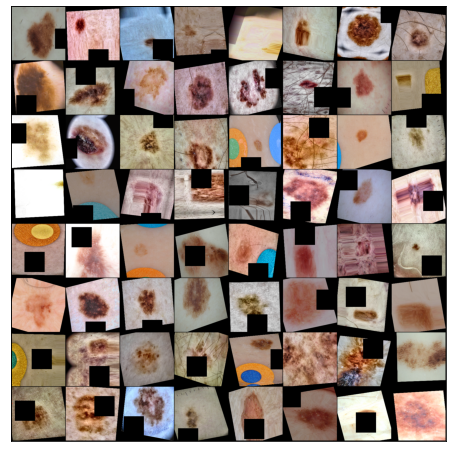

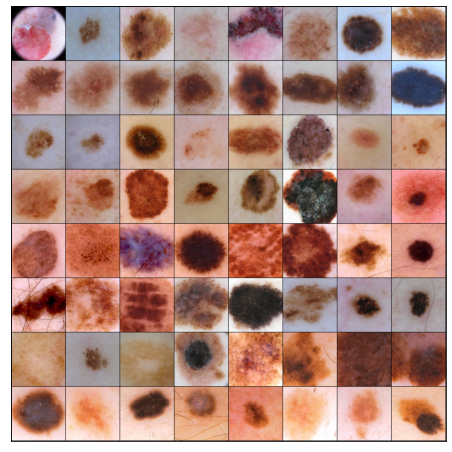

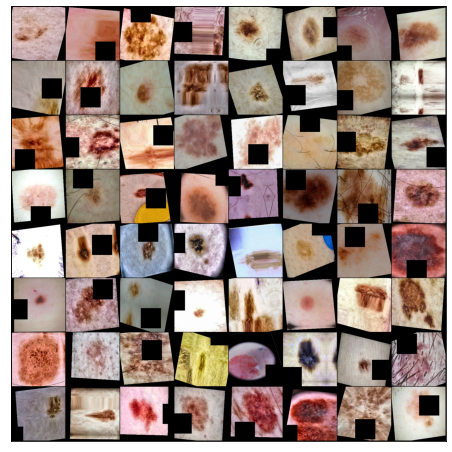

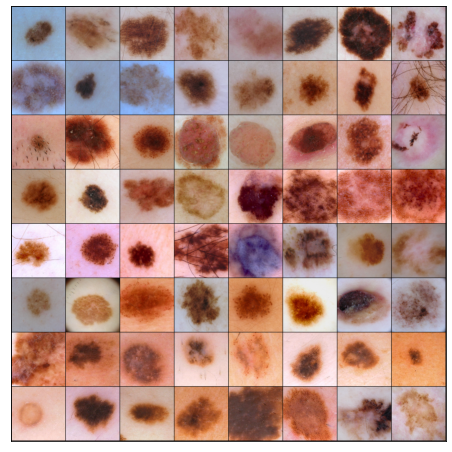

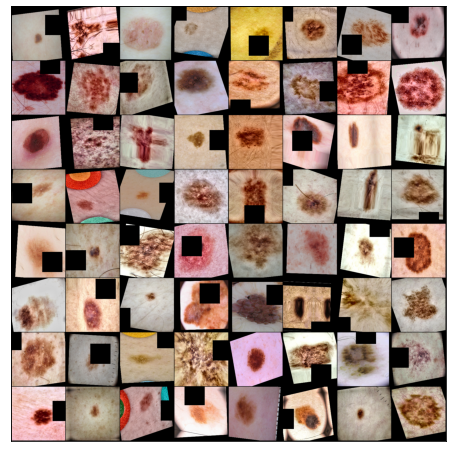

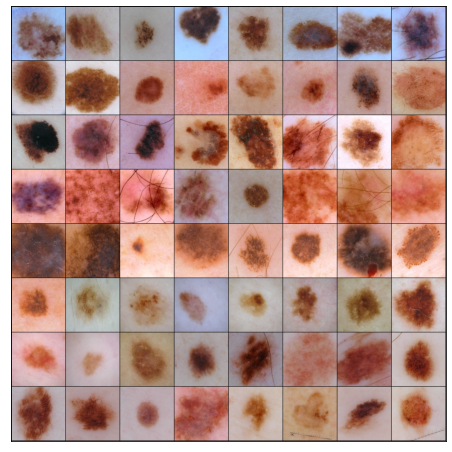

In [ ]:
# aug_transform = transform_aug(params['im_size'])

# for fold in range(KFOLD):
#   train_fold, val_fold = get_folds(train,fold)
#   train_loader, val_loader = data_loader(train_fold, val_fold, transform_tuple= aug_transform, batch_size= params['batch_size'])
#   images, labels = next(iter(train_loader))
#   show_batch(train_loader, denormalize_ = True)
#   show_batch(val_loader, denormalize_ = True)
  

In [ ]:
# show_batch(train_loader, denormalize_ = True)

# Test

## Load Test csv

In [35]:
test_dataset = MelanomaDataset(test['path'], test['target'])
test_loader = DataLoader(test_dataset, batch_size=params['batch_size']*2)

## Hold-out split

In [108]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

aug = 'aug' if params['augmentation'] else 'no_aug'
model_name=params['model']

model = torch.load(f'{PATH}/splits/{model_name}_{aug}.pth',map_location=torch.device(params['device']))
# model = torch.load(f'{PATH}/folds/fold3_{model_name}_{aug}.pth',map_location=torch.device(params['device']))
model.to(params['device'])
model.eval()
preds = torch.tensor([]).to(params['device'])
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
stream = tqdm(test_loader)
metric_monitor = MetricMonitor()
with torch.no_grad():
  for i, batch in enumerate(stream, start=1):
    imgs, targets = batch
    imgs, targets = imgs.to(params['device']), targets.to(params['device'])
    outputs = model(imgs)
    preds = torch.cat([preds, outputs.view(-1)])
    val_outputs = torch.cat([val_outputs, outputs.cpu()])
    val_targets = torch.cat([val_targets, targets.cpu()])
    accuracy = accuracy_score(val_outputs, val_targets)
    auc = auc_score(val_outputs, val_targets)
    f1 = f1_score_(val_outputs, val_targets)
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
    metric_monitor.update("AUC", auc)
    stream.set_description("Test. {metric_monitor}".format(metric_monitor=metric_monitor))
print('INFO: Test completed')
accuracy = accuracy_score(val_outputs, val_targets)
recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
auc = auc_score(val_outputs, val_targets)
f1 = f1_score_(val_outputs, val_targets)
print(f'\nOverall Test. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n')

Test. Accuracy: 0.763 | F1: 0.718 | AUC: 0.655: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]

INFO: Test completed

Overall Test. Accuracy: 0.792, F1: 0.751, AUC: 0.685, Recall: 0.160



### ROC | Classification report

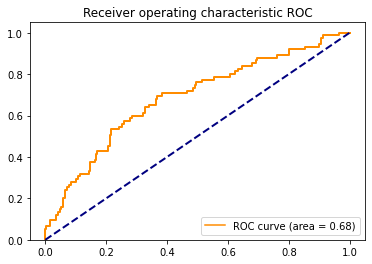

              precision    recall  f1-score   support

      bening       0.95      0.82      0.88       351
   malignant       0.16      0.43      0.23        28

    accuracy                           0.79       379
   macro avg       0.55      0.62      0.56       379
weighted avg       0.89      0.79      0.83       379



<Figure size 432x288 with 0 Axes>

In [109]:
model_name= params['model']
save_roc_curve(val_outputs, val_targets, path=PATH, label=f'ROC {model_name}', plot=True, pos_label=1)
plot_labels = ['bening', 'malignant']
val_outputs_ = val_outputs >= threshold
report = classification_report(val_outputs_, val_targets, target_names=plot_labels)
print(report)

### Confusion matrix

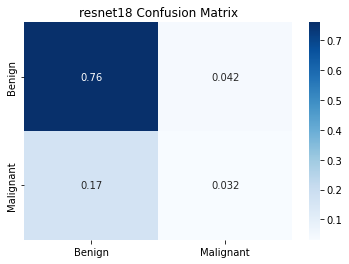

<Figure size 432x288 with 0 Axes>

In [112]:
classes = ('Benign', 'Malignant')
model_name= params['model']
val_outputs_ = val_outputs >= threshold
save_confusion_matrix(val_outputs_, val_targets, path=PATH, label=model_name, classes=classes, plot=True)

## Folds

In [121]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

acc_predict_folds = []
auc_predict_folds = []
f1_predict_folds = []
val_outputs_folds = []
preds_folds = []
for fold in range(params['folds']):
  model = torch.load(f'{PATH}/folds/fold{fold+1}_resnet18_no_aug.pth',map_location=torch.device(params['device']))
  model.to(params['device'])
  model.eval()
  preds = torch.tensor([]).to(params['device'])
  val_outputs = torch.tensor([])
  val_targets = torch.tensor([])
  stream = tqdm(test_loader)
  metric_monitor = MetricMonitor()
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      imgs, targets = batch
      imgs, targets = imgs.to(params['device']), targets.to(params['device'])
      outputs = model(imgs)
      preds = torch.cat([preds, outputs.view(-1)])
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
      val_targets = torch.cat([val_targets, targets.cpu()])
      accuracy = accuracy_score(val_outputs, val_targets)
      auc = auc_score(val_outputs, val_targets)
      f1 = f1_score_(val_outputs, val_targets)
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      metric_monitor.update("AUC", auc)
      stream.set_description("Test. {metric_monitor}".format(metric_monitor=metric_monitor))
  val_outputs_folds.append(val_outputs)
  preds_folds.append(preds.cpu().numpy())
  accuracy = accuracy_score(val_outputs, val_targets)
  recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
  auc = auc_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)
  acc_predict_folds.append(accuracy)
  auc_predict_folds.append(auc)
  f1_predict_folds.append(f1)
  print(f'\nOverall Fold {fold+1} test results. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n\n')
print('INFO: Test completed')
preds_fold_mean = np.mean(preds_folds, axis =0)
acc_avg = np.mean(acc_predict_folds, axis=0)
auc_avg = np.mean(auc_predict_folds, axis=0)
f1_avg = np.mean(f1_predict_folds, axis=0)
print(f'\nAverage test results for all folds. Accuracy: {acc_avg:.3f}, F1: {f1_avg:.3f}, AUC: {auc_avg:.3f}\n')

Test. Accuracy: 0.780 | F1: 0.684 | AUC: 0.652: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it]



Overall Fold 1 test results. Accuracy: 0.805, F1: 0.720, AUC: 0.641, Recall: 0.013




Test. Accuracy: 0.717 | F1: 0.719 | AUC: 0.637: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it]



Overall Fold 2 test results. Accuracy: 0.763, F1: 0.760, AUC: 0.680, Recall: 0.373




Test. Accuracy: 0.763 | F1: 0.718 | AUC: 0.655: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it]


Overall Fold 3 test results. Accuracy: 0.792, F1: 0.751, AUC: 0.685, Recall: 0.160


INFO: Test completed

Average test results for all folds. Accuracy: 0.786, F1: 0.744, AUC: 0.668



### ROC | Classification report

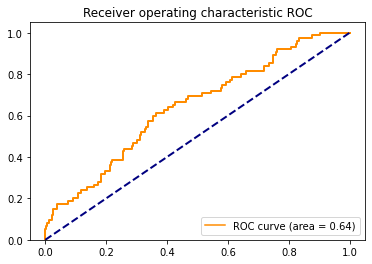

              precision    recall  f1-score   support

      bening       1.00      0.80      0.89       378
   malignant       0.01      1.00      0.03         1

    accuracy                           0.80       379
   macro avg       0.51      0.90      0.46       379
weighted avg       1.00      0.80      0.89       379



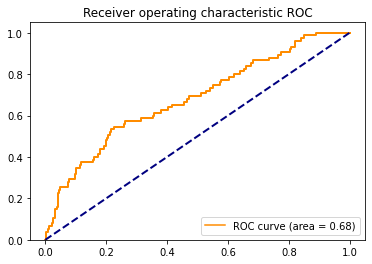

              precision    recall  f1-score   support

      bening       0.86      0.85      0.85       308
   malignant       0.37      0.39      0.38        71

    accuracy                           0.76       379
   macro avg       0.62      0.62      0.62       379
weighted avg       0.77      0.76      0.77       379



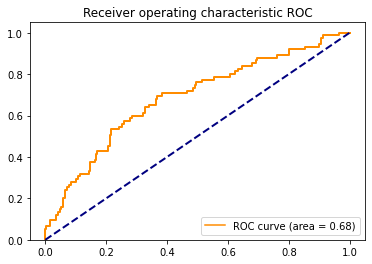

              precision    recall  f1-score   support

      bening       0.95      0.82      0.88       351
   malignant       0.16      0.43      0.23        28

    accuracy                           0.79       379
   macro avg       0.55      0.62      0.56       379
weighted avg       0.89      0.79      0.83       379



<Figure size 432x288 with 0 Axes>

In [120]:
model_name= params['model']
for fold in range(params['folds']):
  save_roc_curve(val_outputs_folds[fold], val_targets, path=PATH, label=f'ROC {model_name}', plot=True, pos_label=1)
  plot_labels = ['bening', 'malignant']
  val_outputs_ = val_outputs_folds[fold] >= threshold
  report = classification_report(val_outputs_, val_targets, target_names=plot_labels)
  print(report)

### Confusion Matrix

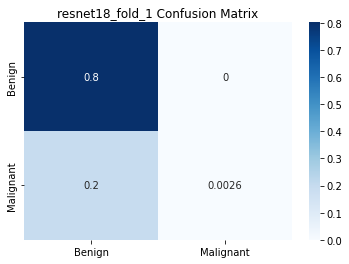

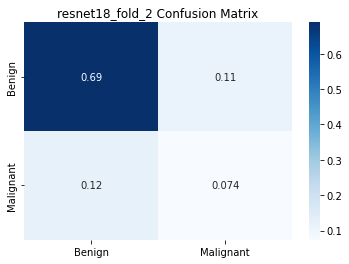

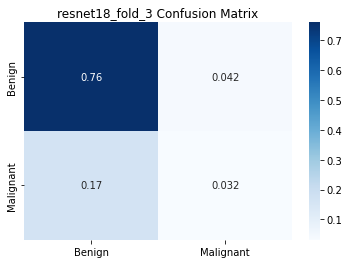

<Figure size 432x288 with 0 Axes>

In [119]:
classes = ('Benign', 'Malignant')
model_name= params['model']
for fold in range(params['folds']):
  val_outputs_ = val_outputs_folds[fold] >= threshold
  save_confusion_matrix(val_outputs_, val_targets, path=PATH, label=model_name+f'_fold_{fold+1}', classes=classes, plot=True)